In [ ]:
#Drive
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statistics
from pprint import pprint
import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import gensim
from gensim.models import Word2Vec, KeyedVectors

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, EarlyStoppingCallback
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import csv
from datetime import datetime
from google.colab import files

# Load Dataframe

In [ ]:
# Load the CSV file
#df = pd.read_csv('./drive/MyDrive/Datafiniti_Hotel_Reviews.csv', encoding='latin1')
df = pd.read_csv('./drive/My Drive/Datafiniti_Hotel_Reviews.csv', encoding='latin1')

In [ ]:
# Print summary statistics for the 'reviews.rating'
summary_stats = df['reviews.rating'].describe()

# Format the summary statistics to show only 2 decimal places
formatted_stats = summary_stats.apply(lambda x: f"{x:.2f}")
print(formatted_stats)

count    10000.00
mean         4.03
std          1.16
min          1.00
25%          3.35
50%          4.00
75%          5.00
max          5.00
Name: reviews.rating, dtype: object


In [ ]:
# Count null values in 'reviews.text' and 'reviews.rating' columns
null_reviews_text = df['reviews.text'].isnull().sum()
null_reviews_rating = df['reviews.rating'].isnull().sum()

print(f'Number of null values in reviews.text: {null_reviews_text}')
print(f'Number of null values in reviews.rating: {null_reviews_rating}')


Number of null values in reviews.text: 1
Number of null values in reviews.rating: 0


In [ ]:
# Locate the row with a null value in 'reviews.text'
null_row = df[df['reviews.text'].isnull()]

print("Row with null value in 'reviews.text':")
print(null_row)

# Remove the row with the null value
hotel_df = df[~df['reviews.text'].isnull()]



# Verify that the row has been removed
null_count_after_removal = hotel_df['reviews.text'].isnull().sum()
print(f'Number of null values in reviews.text after removal: {null_count_after_removal}')


Row with null value in 'reviews.text':
                     ï»¿id             dateAdded           dateUpdated  \
6723  AVwcmcqPkufWRAb5w-y1  2015-10-23T22:32:31Z  2018-03-06T00:33:22Z   

            address               categories              primaryCategories  \
6723  250 Spring St  Hotel,Hotels and motels  Accommodation & Food Services   

            city country                                     keys   latitude  \
6723  Charleston      US  us/sc/charleston/250springst/-518306969  32.786271   

      ...                                   reviews.dateSeen reviews.rating  \
6723  ...  2016-06-18T00:00:00Z,2016-05-25T00:00:00Z,2016...            3.0   

                                     reviews.sourceURLs reviews.text  \
6723  https://www.expedia.com/Charleston-Hotels-Holi...          NaN   

     reviews.title reviews.userCity  reviews.userProvince  \
6723        Review              NaN                   NaN   

         reviews.username                                        

In [ ]:
# Count duplicates in the 'reviews.text' column
duplicate_count = df['reviews.text'].duplicated().sum()
print(f"Number of duplicate reviews: {duplicate_count}")

Number of duplicate reviews: 18


In [ ]:
# Remove all rows where 'reviews.text' is a duplicate, keeping the first occurrence
df = df[~df['reviews.text'].duplicated(keep='first')].reset_index(drop=True)

In [ ]:
num_rows = df.shape[0]
print(f'Number of rows: {num_rows}')

Number of rows: 9982


In [ ]:
df["reviews.rating"].value_counts()

,count
reviews.rating,
5.00,4373
4.00,2395
3.00,1186
1.00,572
2.00,561
4.80,162
4.60,154
4.40,101
3.75,91


In [ ]:
def map_rating_to_sentiment(rating):
    if rating < 2.5:
        return 'negative'
    elif 2.5 <= rating <=3.5 :
        return 'neutral'
    else:
        return 'positive'


In [ ]:
df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,7463
neutral,1344
negative,1175


In [ ]:
df.columns

Index(['ï»¿id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites', 'sentiment'],
      dtype='object')

In [ ]:
hotel_df=df[["reviews.text","sentiment"]]

In [ ]:
hotel_df

,reviews.text,sentiment
0,Our experience at Rancho Valencia was absolute...,positive
1,Amazing place. Everyone was extremely warm and...,positive
2,We booked a 3 night stay at Rancho Valencia to...,positive
3,Currently in bed writing this for the past hr ...,negative
4,I live in Md and the Aloft is my Home away fro...,positive
...,...,...
9977,It is hard for me to review an oceanfront hote...,neutral
9978,"I live close by, and needed to stay somewhere ...",positive
9979,Rolled in 11:30 laid out heads down woke up to...,positive
9980,Absolutely terrible..I was told I was being gi...,negative


In [ ]:
# NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# PREPROCESSING

In [ ]:
# Fill NaN values with an empty string and convert to lowercase
hotel_df['reviews.text'] = hotel_df['reviews.text'].fillna('').astype(str).str.lower()

# Tokenize the text
hotel_df['tokenized_text'] = hotel_df['reviews.text'].apply(word_tokenize)

<ipython-input-27-345693d3880e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['reviews.text'] = hotel_df['reviews.text'].fillna('').astype(str).str.lower()
<ipython-input-27-345693d3880e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['tokenized_text'] = hotel_df['reviews.text'].apply(word_tokenize)


In [ ]:
hotel_df

,reviews.text,sentiment,tokenized_text
0,our experience at rancho valencia was absolute...,positive,"[our, experience, at, rancho, valencia, was, a..."
1,amazing place. everyone was extremely warm and...,positive,"[amazing, place, ., everyone, was, extremely, ..."
2,we booked a 3 night stay at rancho valencia to...,positive,"[we, booked, a, 3, night, stay, at, rancho, va..."
3,currently in bed writing this for the past hr ...,negative,"[currently, in, bed, writing, this, for, the, ..."
4,i live in md and the aloft is my home away fro...,positive,"[i, live, in, md, and, the, aloft, is, my, hom..."
...,...,...,...
9977,it is hard for me to review an oceanfront hote...,neutral,"[it, is, hard, for, me, to, review, an, oceanf..."
9978,"i live close by, and needed to stay somewhere ...",positive,"[i, live, close, by, ,, and, needed, to, stay,..."
9979,rolled in 11:30 laid out heads down woke up to...,positive,"[rolled, in, 11:30, laid, out, heads, down, wo..."
9980,absolutely terrible..i was told i was being gi...,negative,"[absolutely, terrible, .., i, was, told, i, wa..."


In [ ]:
label_encoder = LabelEncoder()

# Fit the label encoder and transform the sentiment labels
hotel_df['sentiment_enc'] = label_encoder.fit_transform(hotel_df['sentiment'])

# Check the mapping of labels to confirm
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


<ipython-input-29-d1afc5fe2129>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['sentiment_enc'] = label_encoder.fit_transform(hotel_df['sentiment'])


In [ ]:
import string
from nltk.corpus import stopwords

nltk.download('stopwords')

# Define stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Function to remove stopwords and punctuation from tokenized text
def remove_stopwords_punctuation(tokens):
    return [word for word in tokens if word not in stop_words and word not in punctuation]

# Apply the function to the tokenized text column
hotel_df['cleaned_text'] = hotel_df['tokenized_text'].apply(remove_stopwords_punctuation)

# Show the updated dataframe with cleaned text
hotel_df[['tokenized_text', 'cleaned_text']].head()

NameError: name 'nltk' is not defined

# WORD2VEC

In [ ]:
# train the word2vec model with our cleaned data
model = Word2Vec(sentences=hotel_df["cleaned_text"], seed=0, workers=4, sg=0)

In [ ]:
list(hotel_df.cleaned_text.iloc[[10]])

[['staff',
  'friendly',
  'helpful',
  'rooms',
  'large',
  'nicely',
  'furnished',
  'feels',
  'new',
  'first',
  'stay',
  'actually',
  'opulent',
  'require',
  'free',
  'breakfast',
  'good',
  'sufficient',
  'choices',
  'including',
  'fresh',
  'fruit',
  'salad',
  'eggs',
  'bacon',
  'bagels',
  'pastries',
  'great',
  'location',
  'purpose',
  '...']]

In [ ]:
def sentence_to_embedding(cleaned_text, model):
    # Initialize an array to hold the sum of the word vectors
    embedding_sum = np.zeros(model.vector_size)
    valid_word_count = 0

    # Sum up the embeddings for each word in the sentence
    for word in cleaned_text:
        if word in model.wv:
            embedding_sum += model.wv[word]
            valid_word_count += 1

    # Compute the average by dividing by the number of valid words
    if valid_word_count > 0:
        embedding_sum /= valid_word_count

    return embedding_sum

# Example usage:
example_sentence = list(hotel_df.cleaned_text.iloc[[10]])[0]
sentence_embedding = sentence_to_embedding(example_sentence, model)

print("Shape of the sentence embedding:", sentence_embedding.shape)
print("Review embedding:", sentence_embedding)

Shape of the sentence embedding: (100,)
Review embedding: [ 0.20847921 -0.09259486 -0.03413177 -0.60236291  0.26774395  0.14672076
 -0.02418195 -0.20757328  0.10120165  0.10243672 -0.2291071  -0.12246136
 -0.18723636  0.58026011  0.08145667  0.18993754  0.2962521  -0.32902093
 -0.02047765  0.3380156  -0.08519778  0.25226776  0.07323272  0.02483041
  0.61824127  0.15271696  0.00630233 -0.05437676 -0.4983956  -0.056802
  0.19231296  0.20282106  0.54047929  0.01471182 -0.54237351  0.18445842
  0.52608469 -0.18955637 -0.17055317 -0.08008244  0.03273975 -0.22892527
 -0.14477608  0.05928694  0.18919142 -0.28364538 -0.34070052 -0.11153632
 -0.03439223  0.1041305  -0.26101331  0.36887536 -0.26985881  0.67739091
 -0.06282123 -0.6011057  -0.36098404  0.18019542  0.05731143  0.13319073
 -0.25877147  0.25232016 -0.01400745  0.20449996  0.63685908 -0.07587245
 -0.3187118   0.04662054  0.12974499 -0.08333562 -0.89232122  0.28452796
 -0.2378633   0.12142012  0.39769004  0.40109042 -0.04866199 -0.0642

In [ ]:
print(example_sentence)

['staff', 'friendly', 'helpful', 'rooms', 'large', 'nicely', 'furnished', 'feels', 'new', 'first', 'stay', 'actually', 'opulent', 'require', 'free', 'breakfast', 'good', 'sufficient', 'choices', 'including', 'fresh', 'fruit', 'salad', 'eggs', 'bacon', 'bagels', 'pastries', 'great', 'location', 'purpose', '...']


In [ ]:
hotel_df.sentiment.value_counts()

,count
sentiment,
positive,7463
neutral,1344
negative,1175


In [ ]:
# Create embeddings from the tokenized text using your Word2Vec model
hotel_df['embeddings'] = hotel_df['cleaned_text'].apply(lambda x: sentence_to_embedding(x, model))

# Convert the embeddings and labels to numpy arrays
X = np.vstack(hotel_df['embeddings'].values)
y = hotel_df['sentiment_enc'].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)


<ipython-input-56-e0698a91ed06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['embeddings'] = hotel_df['cleaned_text'].apply(lambda x: sentence_to_embedding(x, model))


In [ ]:
hotel_df

,reviews.text,sentiment,tokenized_text,sentiment_enc,cleaned_text,embeddings,cleaned_text_joined
0,our experience at rancho valencia was absolute...,positive,"[our, experience, at, rancho, valencia, was, a...",2,"[experience, rancho, valencia, absolutely, per...","[0.1042426800976197, -0.355593810028707, 0.009...",experience rancho valencia absolutely perfect ...
1,amazing place. everyone was extremely warm and...,positive,"[amazing, place, ., everyone, was, extremely, ...",2,"[amazing, place, everyone, extremely, warm, we...","[0.07534818860585801, -0.2874281636941305, -0....",amazing place everyone extremely warm welcomin...
2,we booked a 3 night stay at rancho valencia to...,positive,"[we, booked, a, 3, night, stay, at, rancho, va...",2,"[booked, 3, night, stay, rancho, valencia, pla...","[0.11311380302843949, -0.20175661978104875, -0...",booked 3 night stay rancho valencia play tenni...
3,currently in bed writing this for the past hr ...,negative,"[currently, in, bed, writing, this, for, the, ...",0,"[currently, bed, writing, past, hr, 1/2, dogs,...","[-0.11862689582630992, -0.0690496001196535, -0...",currently bed writing past hr 1/2 dogs barking...
4,i live in md and the aloft is my home away fro...,positive,"[i, live, in, md, and, the, aloft, is, my, hom...",2,"[live, md, aloft, home, away, home, ..., staye...","[-0.02553126949816942, -0.19102490767836572, 0...",live md aloft home away home ... stayed 1 nigh...
...,...,...,...,...,...,...,...
9977,it is hard for me to review an oceanfront hote...,neutral,"[it, is, hard, for, me, to, review, an, oceanf...",1,"[hard, review, oceanfront, hotel, go, ocean, n...","[0.14583337540702465, -0.12382735242135823, -0...",hard review oceanfront hotel go ocean necessar...
9978,"i live close by, and needed to stay somewhere ...",positive,"[i, live, close, by, ,, and, needed, to, stay,...",2,"[live, close, needed, stay, somewhere, night, ...","[-0.06646690471097827, -0.0012867691926658153,...",live close needed stay somewhere night due ren...
9979,rolled in 11:30 laid out heads down woke up to...,positive,"[rolled, in, 11:30, laid, out, heads, down, wo...",2,"[rolled, 11:30, laid, heads, woke, continental...","[0.24693015231085674, 0.010529824072450754, -0...",rolled 11:30 laid heads woke continental break...
9980,absolutely terrible..i was told i was being gi...,negative,"[absolutely, terrible, .., i, was, told, i, wa...",0,"[absolutely, terrible, .., told, given, non, s...","[-0.04729347867358133, -0.09182925196364522, -...",absolutely terrible .. told given non smoking ...


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoaders for batching

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
X_train

tensor([[ 0.1286, -0.0535, -0.0209,  ...,  0.1090, -0.1906,  0.2655],
        [-0.1198, -0.2452, -0.0506,  ...,  0.0353, -0.2111, -0.0038],
        [ 0.1106,  0.0212,  0.0284,  ...,  0.0404, -0.2301,  0.2029],
        ...,
        [ 0.1391, -0.2404, -0.0593,  ...,  0.1598, -0.1891,  0.0331],
        [ 0.6044,  0.0203, -0.0586,  ...,  0.2943, -0.1774, -0.0058],
        [ 0.1497, -0.4355,  0.0803,  ..., -0.0232, -0.2732,  0.1971]])

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Set up model parameters
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 3

# Initialize the model, loss function, and optimizer
model = SimpleMLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
model

SimpleMLP(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
# Training loop
num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training")


Epoch [1/20], Loss: 0.6181
Epoch [2/20], Loss: 0.5630
Epoch [3/20], Loss: 0.5549
Epoch [4/20], Loss: 0.5472
Epoch [5/20], Loss: 0.5418
Epoch [6/20], Loss: 0.5368
Epoch [7/20], Loss: 0.5358
Epoch [8/20], Loss: 0.5351
Epoch [9/20], Loss: 0.5321
Epoch [10/20], Loss: 0.5299
Epoch [11/20], Loss: 0.5254
Epoch [12/20], Loss: 0.5237
Epoch [13/20], Loss: 0.5255
Epoch [14/20], Loss: 0.5217
Epoch [15/20], Loss: 0.5227
Epoch [16/20], Loss: 0.5210
Epoch [17/20], Loss: 0.5184
Epoch [18/20], Loss: 0.5201
Epoch [19/20], Loss: 0.5175
Epoch [20/20], Loss: 0.5156
Finished Training


Accuracy: 78.97%
Precision: 0.7383
Recall: 0.7897
F1 Score: 0.7334
Validation Loss: 0.5420


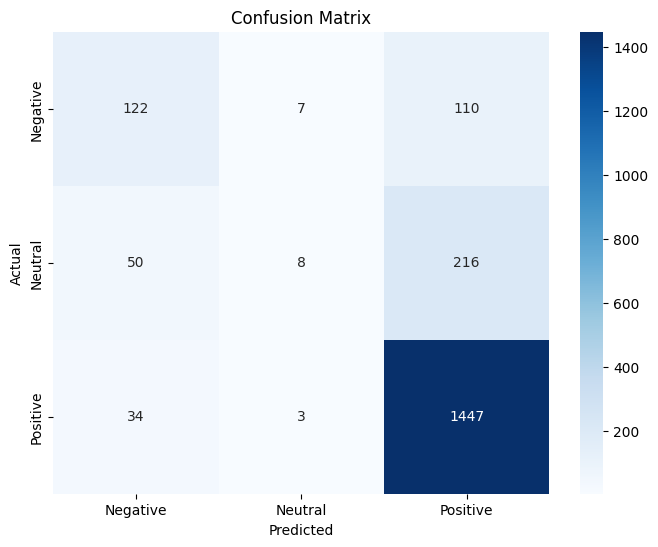

In [ ]:
model_name = 'word2vec'

# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the model
model.eval()  # Set model to evaluation mode

running_val_loss = 0.0  # To store the accumulated validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss (optional)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print metrics and validation loss to console
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation Loss: {avg_val_loss:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')


download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# WORD2VEC 3 LAYERS

In [ ]:
# Define the neural network model with 3 hidden layers
class Word2VecMLP_3Layers(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(Word2VecMLP_3Layers, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

# Set up model parameters
input_dim = X_train.shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
output_dim = 3

# Initialize the model, loss function, and optimizer
model = Word2VecMLP_3Layers(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training")

Epoch [1/20], Loss: 0.6096
Epoch [2/20], Loss: 0.5659
Epoch [3/20], Loss: 0.5486
Epoch [4/20], Loss: 0.5403
Epoch [5/20], Loss: 0.5404
Epoch [6/20], Loss: 0.5285
Epoch [7/20], Loss: 0.5343
Epoch [8/20], Loss: 0.5286
Epoch [9/20], Loss: 0.5283
Epoch [10/20], Loss: 0.5230
Epoch [11/20], Loss: 0.5217
Epoch [12/20], Loss: 0.5206
Epoch [13/20], Loss: 0.5186
Epoch [14/20], Loss: 0.5172
Epoch [15/20], Loss: 0.5109
Epoch [16/20], Loss: 0.5115
Epoch [17/20], Loss: 0.5092
Epoch [18/20], Loss: 0.5087
Epoch [19/20], Loss: 0.5037
Epoch [20/20], Loss: 0.5035
Finished Training


Accuracy: 79.32%
Precision: 0.7391
Recall: 0.7932
F1 Score: 0.7433
Validation Loss: 0.5474


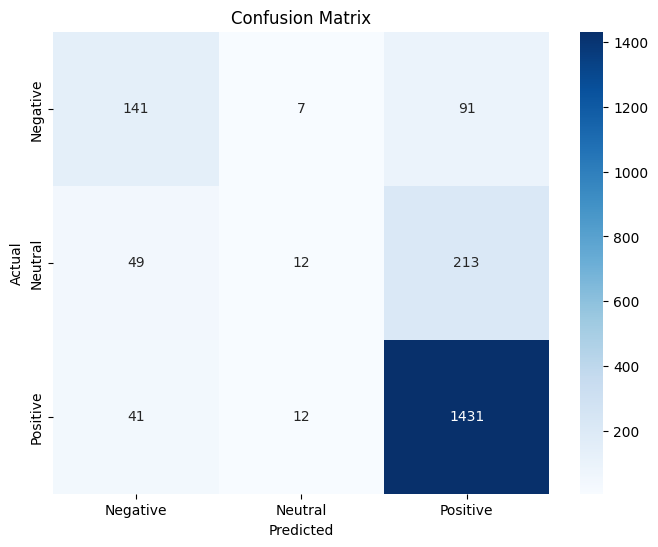

In [ ]:
model_name = 'word2vec_3_layers'

# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the model
model.eval()  # Set model to evaluation mode

running_val_loss = 0.0  # To store the accumulated validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss (optional)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print metrics and validation loss
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation Loss: {avg_val_loss:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')


download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# WORD2VEC_4LAYERS

In [ ]:
# Define the neural network model with 4 hidden layers
class Word2VecMLP_4Layers(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Word2VecMLP_4Layers, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

# Set up model parameters
input_dim = X_train.shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
output_dim = 3

# Initialize the model, loss function, and optimizer
model = Word2VecMLP_4Layers(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Finished Training")

Epoch [1/20], Loss: 0.6339
Epoch [2/20], Loss: 0.5656
Epoch [3/20], Loss: 0.5526
Epoch [4/20], Loss: 0.5458
Epoch [5/20], Loss: 0.5369
Epoch [6/20], Loss: 0.5362
Epoch [7/20], Loss: 0.5322
Epoch [8/20], Loss: 0.5297
Epoch [9/20], Loss: 0.5306
Epoch [10/20], Loss: 0.5256
Epoch [11/20], Loss: 0.5253
Epoch [12/20], Loss: 0.5205
Epoch [13/20], Loss: 0.5243
Epoch [14/20], Loss: 0.5195
Epoch [15/20], Loss: 0.5186
Epoch [16/20], Loss: 0.5179
Epoch [17/20], Loss: 0.5161
Epoch [18/20], Loss: 0.5106
Epoch [19/20], Loss: 0.5129
Epoch [20/20], Loss: 0.5127
Finished Training


Accuracy: 79.32%
Precision: 0.7351
Recall: 0.7932
F1 Score: 0.7328
Validation Loss: 0.5416


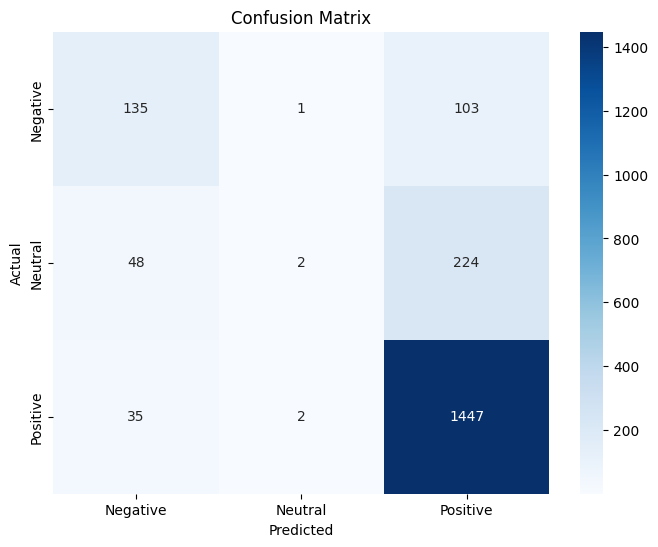

In [ ]:
model_name = 'word2vec_4_layers'

# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the model
model.eval()  # Set model to evaluation mode

running_val_loss = 0.0  # To store the accumulated validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss (optional)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print metrics and validation loss to console
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation Loss: {avg_val_loss:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')

download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TFIDF


In [ ]:
# Use the cleaned_text column
X = hotel_df['cleaned_text'].apply(lambda x: ' '.join(x)).values
y = hotel_df['sentiment_enc'].values

# Vectorize text data with TF-IDF and remove stopwords
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [ ]:
# Split the data into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Convert TF-IDF matrices to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# Define the SimpleMLP model for TF-IDF
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Set up model parameters
input_dim = X_train_tensor.shape[1]
hidden_dim = 128
output_dim = 3

In [ ]:
# Initialize the model, loss function, and optimizer
tfidf_model = SimpleMLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tfidf_model.parameters(), lr=0.001)


In [ ]:
# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
tfidf_model = tfidf_model.to(device)

# Training loop
num_epochs = 7 # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    tfidf_model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = tfidf_model(b_input_ids)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

print("Training complete.")

Epoch 1/7, Loss: 0.6481
Epoch 2/7, Loss: 0.4055
Epoch 3/7, Loss: 0.2797
Epoch 4/7, Loss: 0.1797
Epoch 5/7, Loss: 0.1139
Epoch 6/7, Loss: 0.0727
Epoch 7/7, Loss: 0.0486
Training complete.


Accuracy: 79.32%
Precision: 0.7661
Recall: 0.7932
F1 Score: 0.7750
Validation Loss: 0.7601


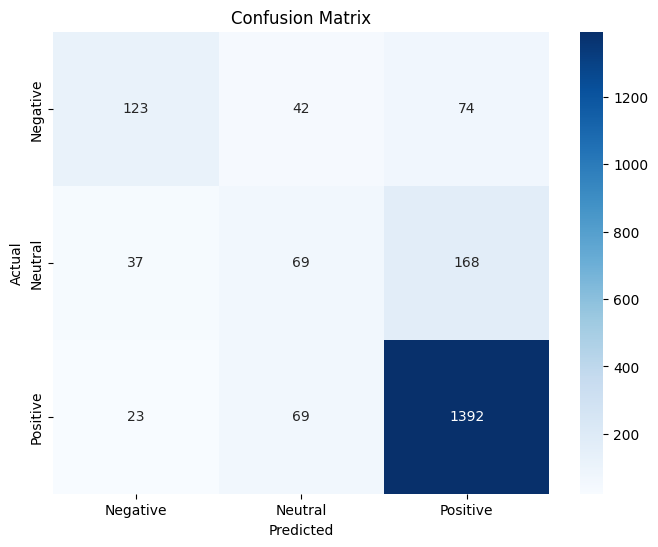

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the model
tfidf_model.eval()  # Set model to evaluation mode

running_val_loss = 0.0  # To store the accumulated validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = tfidf_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print metrics and validation loss to console
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation Loss: {avg_val_loss:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), 'tfidf_model', accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')

download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TF-IDF 3 LAYERS

In [ ]:
# Define the SimpleMLP model for TF-IDF with 3 hidden layers
class SimpleMLP_3Layers(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP_3Layers, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

# Set up model parameters
input_dim = X_train_tensor.shape[1]  #
hidden_dim = 128

# Initialize the model
model = SimpleMLP_3Layers(input_dim, hidden_dim, output_dim)

In [ ]:
# Initialize the model, loss function, and optimizer
tfidf_model = SimpleMLP_3Layers(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(tfidf_model.parameters(), lr=0.001)

In [ ]:
# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
tfidf_model = tfidf_model.to(device)

# Training loop
num_epochs = 4 # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    tfidf_model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = tfidf_model(b_input_ids)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

print("Training complete.")

Epoch 1/4, Loss: 0.5912
Epoch 2/4, Loss: 0.3709
Epoch 3/4, Loss: 0.2303
Epoch 4/4, Loss: 0.1080
Training complete.


Accuracy: 79.32%
Precision: 0.7758
Recall: 0.7932
F1 Score: 0.7823
Validation Loss: 0.8526


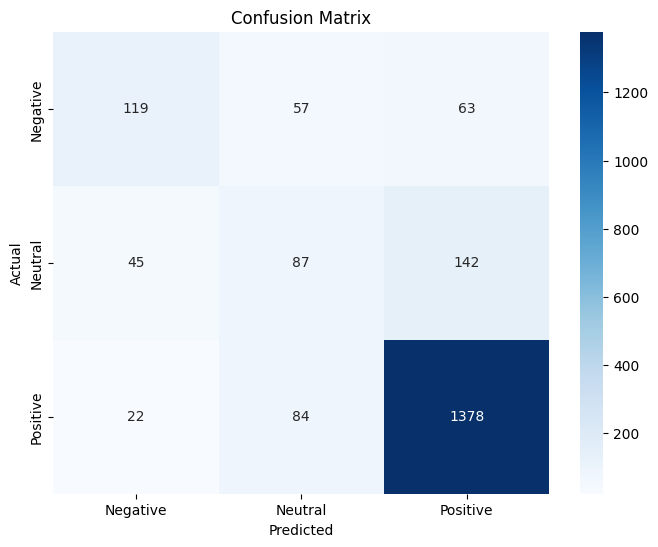

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the model
tfidf_model.eval()  # Set model to evaluation mode

running_val_loss = 0.0  # To store the accumulated validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = tfidf_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print metrics and validation loss to console
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation Loss: {avg_val_loss:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), 'tfidf_model', accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')

download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TF-IDF 4 LAYERS

In [ ]:
# Define the SimpleMLP model for TF-IDF with 4 hidden layers
class SimpleMLP_4Layers(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP_4Layers, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

# Set up model parameters
input_dim = X_train_tensor.shape[1]
hidden_dim = 128
output_dim = 3

# Initialize the model
model = SimpleMLP_4Layers(input_dim, hidden_dim, output_dim)

In [ ]:
# Initialize the model, loss function, and optimizer
tfidf_model = SimpleMLP_4Layers(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(tfidf_model.parameters(), lr=0.001)

In [ ]:
# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
tfidf_model = tfidf_model.to(device)

# Training loop
num_epochs = 4 # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    tfidf_model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = tfidf_model(b_input_ids)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

print("Training complete.")

Epoch 1/4, Loss: 0.6006
Epoch 2/4, Loss: 0.3778
Epoch 3/4, Loss: 0.2442
Epoch 4/4, Loss: 0.1425
Training complete.


Accuracy: 78.32%
Precision: 0.7923
Recall: 0.7832
F1 Score: 0.7809
Validation Loss: 0.7803


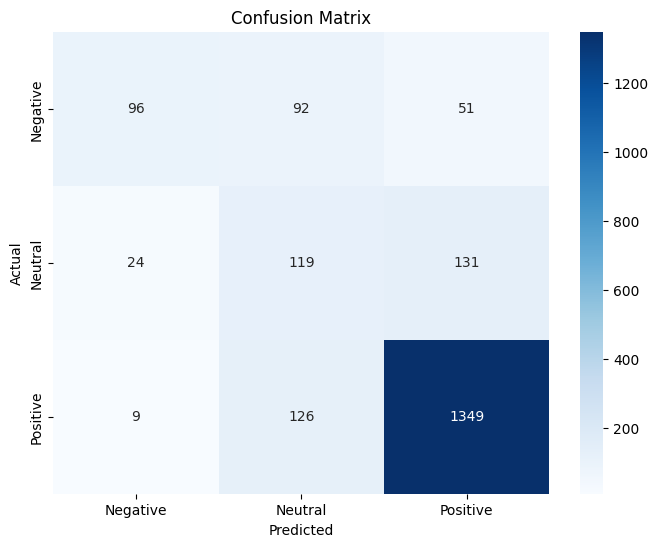

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the model
tfidf_model.eval()  # Set model to evaluation mode

running_val_loss = 0.0  # To store the accumulated validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = tfidf_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate precision, recall, f1-score, and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print metrics and validation loss to console
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Validation Loss: {avg_val_loss:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), 'tfidf_model', accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')


download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LOGISTIC REGRESSION

In [ ]:
# Ensure 'cleaned_text' is a single string by joining tokens
hotel_df['cleaned_text_joined'] = hotel_df['cleaned_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

texts = hotel_df['cleaned_text_joined'].values  # Using the cleaned text directly as an array
labels = hotel_df['sentiment_enc'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the train data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_tfidf)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

<ipython-input-47-54e63620e57f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['cleaned_text_joined'] = hotel_df['cleaned_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


Accuracy: 82.32%
Precision: 0.7948
Recall: 0.8232
F1 Score: 0.7876
Confusion Matrix:
[[ 137   15   83]
 [  39   42  188]
 [  13   15 1465]]


In [ ]:
# Save evaluation metrics and confusion matrix to a CSV file
with open('logistic_regression_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the metrics
    writer.writerow([datetime.now(), 'Logistic Regression', accuracy * 100, precision, recall, f1])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    writer.writerows(conf_matrix)

print("Results saved to logistic_regression_results.csv")

files.download('logistic_regression_results.csv')

Results saved to logistic_regression_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# FastText embeddings

In [ ]:
#  NLTK resources
nltk.download('punkt')

# Load the FastText model from the .vec file
fasttext_model_path = './drive/My Drive/wiki-news-300d-1M.vec'
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False, limit=100000)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Function to convert a sentence into its FastText embedding
def sentence_to_embedding_fasttext(text, model):
    # Tokenize the cleaned text
    tokenized_text = word_tokenize(text.lower())
    embedding_sum = np.zeros(model.vector_size)
    valid_word_count = 0

    for word in tokenized_text:
        if word in model:
            embedding_sum += model[word]
            valid_word_count += 1

    if valid_word_count > 0:
        embedding_sum /= valid_word_count

    return embedding_sum


In [ ]:
# Generate embeddings for each review and store in a new column
hotel_df['fasttext_embeddings'] = hotel_df['cleaned_text_joined'].apply(
    lambda x: sentence_to_embedding_fasttext(x, fasttext_model)
)
# Prepare the data for training
X = np.vstack(hotel_df['fasttext_embeddings'].values)  # Convert embeddings to a numpy array
y = hotel_df['sentiment_enc'].values  # Sentiment labels

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


<ipython-input-75-f7ea08585ee8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_df['fasttext_embeddings'] = hotel_df['cleaned_text_joined'].apply(


In [ ]:
# Create DataLoaders for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [ ]:
# Define the neural network (SimpleMLP)
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 3

fasttext_model = SimpleMLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(fasttext_model.parameters(), lr=0.001)



In [ ]:
# Train the model
num_epochs = 20

for epoch in range(num_epochs):
    fasttext_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = fasttext_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model on the test set
fasttext_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = fasttext_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 0.6695
Epoch [2/20], Loss: 0.5299
Epoch [3/20], Loss: 0.5031
Epoch [4/20], Loss: 0.4865
Epoch [5/20], Loss: 0.4781
Epoch [6/20], Loss: 0.4696
Epoch [7/20], Loss: 0.4609
Epoch [8/20], Loss: 0.4558
Epoch [9/20], Loss: 0.4510
Epoch [10/20], Loss: 0.4466
Epoch [11/20], Loss: 0.4410
Epoch [12/20], Loss: 0.4407
Epoch [13/20], Loss: 0.4345
Epoch [14/20], Loss: 0.4296
Epoch [15/20], Loss: 0.4274
Epoch [16/20], Loss: 0.4241
Epoch [17/20], Loss: 0.4199
Epoch [18/20], Loss: 0.4151
Epoch [19/20], Loss: 0.4107
Epoch [20/20], Loss: 0.4080
Accuracy of the model on the test set: 79.87%


In [ ]:
# Set the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
fasttext_model.to(device)

SimpleMLP(
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

Accuracy: 79.87%
Precision: 0.7536
Recall: 0.7987
F1 Score: 0.7673
Confusion Matrix:
[[ 134   38   67]
 [  51   37  186]
 [  26   34 1424]]
Validation Loss: 0.5016


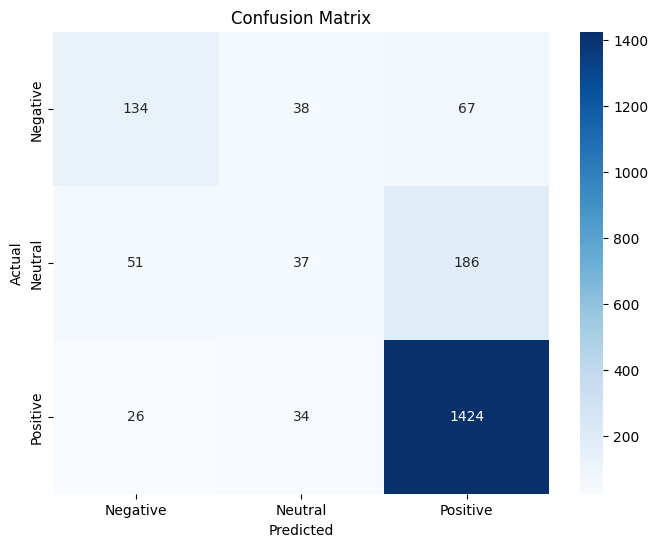

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the fasttext_model
fasttext_model.eval()  # Set model to evaluation mode
correct = 0
total = 0
running_val_loss = 0.0  # To accumulate validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = fasttext_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print the validation loss
print(f'Validation Loss: {avg_val_loss:.4f}')

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
model_name = 'fasttext_model'
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    for row in conf_matrix:
        writer.writerow(row)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')

download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


# fast text hidden 4


In [ ]:
# Define the neural network (Modified SimpleMLP with 4 layers)
class SimpleMLP4(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(SimpleMLP4, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()

        # Third hidden layer
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()

        # Fourth hidden layer
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.relu4 = nn.ReLU()

        # Output layer
        self.fc5 = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x):
        # Forward pass through the layers
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
output_dim = 3

model4 = SimpleMLP4(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model4.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 7

for epoch in range(num_epochs):
    model4.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/7], Loss: 0.6343
Epoch [2/7], Loss: 0.5076
Epoch [3/7], Loss: 0.4917
Epoch [4/7], Loss: 0.4761
Epoch [5/7], Loss: 0.4670
Epoch [6/7], Loss: 0.4573
Epoch [7/7], Loss: 0.4441


In [ ]:
# Set the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model4.to(device)

SimpleMLP4(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=32, out_features=3, bias=True)
)

Accuracy: 80.72%
Precision: 0.7668
Recall: 0.8072
F1 Score: 0.7745
Confusion Matrix:
[[ 133   35   71]
 [  32   42  200]
 [  22   25 1437]]
Validation Loss: 0.4997


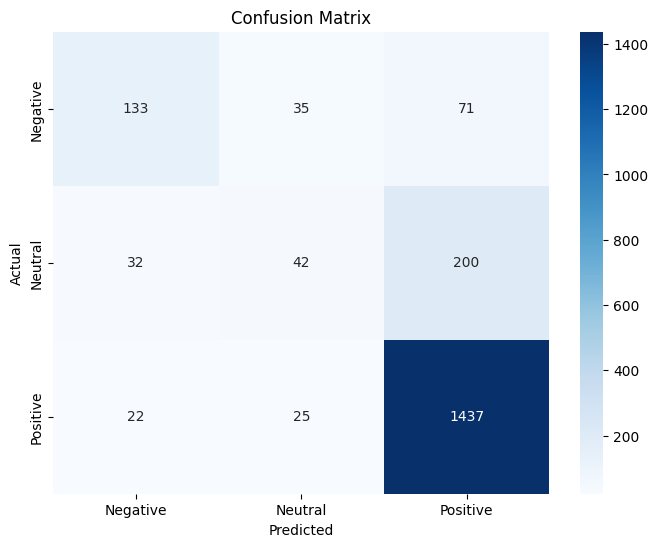

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the fasttext_model
model4.eval()  # Set model to evaluation mode
correct = 0
total = 0
running_val_loss = 0.0  # To accumulate validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model4(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print the validation loss
print(f'Validation Loss: {avg_val_loss:.4f}')

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file
model_name = 'model4'  # Adjust the model name as needed
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    for row in conf_matrix:
        writer.writerow(row)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')


download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fasttext 3 layers

In [ ]:
# Define the neural network (Modified SimpleMLP with 3 layers)
class SimpleMLP3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(SimpleMLP3, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()

        # Third hidden layer
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()

        # Output layer
        self.fc4 = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        # Forward pass through the layers
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
output_dim = 3

model3 = SimpleMLP3(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model3.parameters(), lr=0.001)




In [ ]:
# Training loop
num_epochs = 4

for epoch in range(num_epochs):
    model3.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/4], Loss: 0.6210
Epoch [2/4], Loss: 0.5051
Epoch [3/4], Loss: 0.4817
Epoch [4/4], Loss: 0.4726


In [ ]:
# Set the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model3.to(device)

SimpleMLP3(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)

Accuracy: 80.92%
Precision: 0.7679
Recall: 0.8092
F1 Score: 0.7734
Confusion Matrix:
[[ 156   23   60]
 [  59   31  184]
 [  37   18 1429]]
Validation Loss: 0.4897


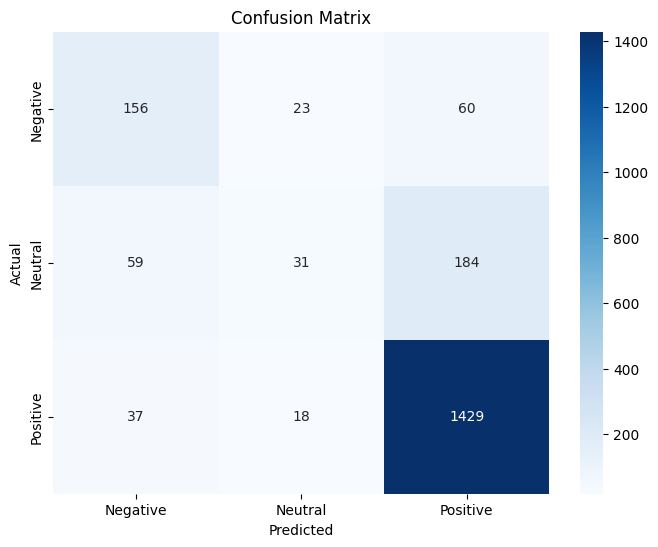

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the fasttext_model
model3.eval()  # Set model to evaluation mode
correct = 0
total = 0
running_val_loss = 0.0  # To accumulate validation loss

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(test_loader)

# Print the validation loss
print(f'Validation Loss: {avg_val_loss:.4f}')

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file (overwrite mode)
model_name = 'model3'
with open('evaluation_results.csv', 'a', newline='') as f:
    writer = csv.writer(f)

    # Write the header if the file is empty
    if f.tell() == 0:
        writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    for row in conf_matrix:
        writer.writerow(row)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')


download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# self atention / Bert

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom Dataset class
class HotelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Extract texts and labels using the cleaned_text column
texts = hotel_df['tokenized_text'].apply(lambda x: ' '.join(x)).tolist()
labels = hotel_df['sentiment_enc'].tolist()

# Split the dataset into training and evaluation sets
train_df, eval_df = train_test_split(
    hotel_df,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create datasets
MAX_LEN = 128
train_dataset = HotelDataset(
    texts=train_df['tokenized_text'].apply(lambda x: ' '.join(x)).tolist(),
    labels=train_df['sentiment_enc'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

eval_dataset = HotelDataset(
    texts=eval_df['tokenized_text'].apply(lambda x: ' '.join(x)).tolist(),
    labels=eval_df['sentiment_enc'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8)

# Function to compute metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize Trainer with the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics  # Add the custom compute_metrics function
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.970100
20,0.939300
30,0.906700
40,0.846300
50,0.828500
60,0.779700
70,0.664800
80,0.804200
90,0.699900
100,0.830900


Accuracy: 85.03%
Precision: 0.8501
Recall: 0.8503
F1 Score: 0.8499
Confusion Matrix:
[[ 165   56   14]
 [  38  134   97]
 [   8   86 1399]]
Validation Loss: 0.5978


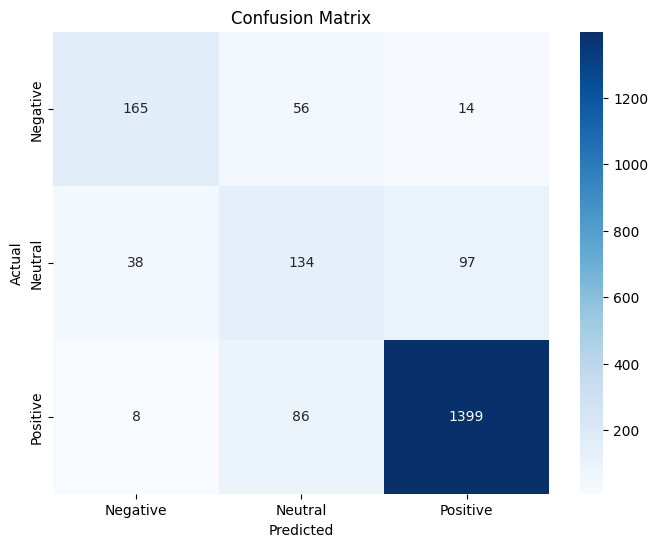

In [ ]:
# Initialize lists to store true and predicted labels
all_preds = []
all_labels = []

# Evaluate the BERT model
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
running_val_loss = 0.0  # To accumulate validation loss

# Define the loss criterion

with torch.no_grad():
    for batch in eval_loader:  # Use eval_loader for evaluation
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate validation loss
        loss = criterion(logits, labels)
        running_val_loss += loss.item()

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate average validation loss
avg_val_loss = running_val_loss / len(eval_loader)

# Print the validation loss
print(f'Validation Loss: {avg_val_loss:.4f}')

# Save evaluation metrics, confusion matrix, validation loss, and model name to a CSV file (overwrite mode)
model_name = 'BERT Model'
with open('evaluation_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(['Timestamp', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Validation Loss'])

    # Write the metrics and validation loss
    writer.writerow([datetime.now(), model_name, accuracy * 100, precision, recall, f1, avg_val_loss])

    # Add the confusion matrix with a title
    writer.writerow(['Confusion Matrix'])
    for row in conf_matrix:
        writer.writerow(row)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


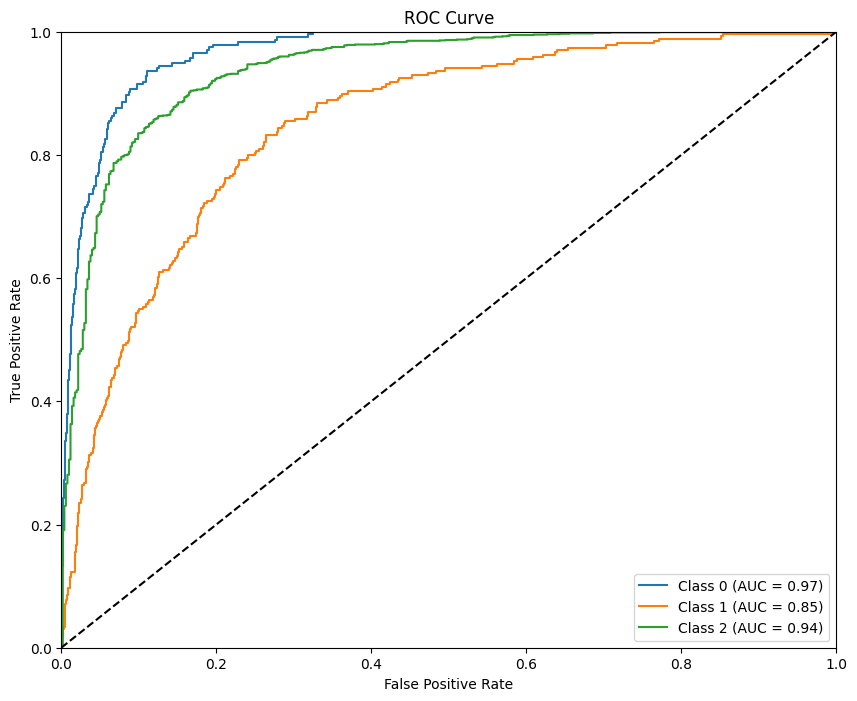

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Initialize lists to store probabilities and true labels
all_probs = []
all_labels = []

# Evaluate the BERT model and get probabilities
with torch.no_grad():
    for batch in eval_loader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get the probabilities using softmax
        probs = torch.softmax(logits, dim=1)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Binarize the output
n_classes = 3  # Update based on your number of classes
all_labels = label_binarize(all_labels, classes=[0, 1, 2])
all_probs = np.array(all_probs)

# Plot ROC Curve
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Function to download the CSV file
def download_csv():
    files.download('evaluation_results.csv')


download_csv()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ROBERTA

In [ ]:
"""## Transformers Roberta"""

# from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback,TextDataset
# from sklearn.model_selection import StratifiedGroupKFold
# from sklearn.utils.class_weight import compute_class_weight
# from torch.utils.data import Dataset
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments
# from transformers import Trainer, EarlyStoppingCallback
# import torch
# from torch.utils.data import Dataset
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight
# import os
# from sklearn.metrics import precision_recall_fscore_support
# Main function for stratified group k-fold cross-validation
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

hotel_df.sentiment.value_counts()

X = hotel_df["reviews.text"]
y = hotel_df['sentiment_enc'].values

test=hotel_df["reviews.text"].iloc[[0]].tolist()[0]

test

# Tokenize the sentence
tokens = tokenizer.tokenize(test)

# Convert tokens to IDs (the model will use IDs during training)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

token_ids

from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(hotel_df, test_size=0.2, random_state=42, stratify=hotel_df['sentiment_enc'])

val_df.sentiment.value_counts()

import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create datasets
train_dataset = TextDataset(tokenizer, train_df["reviews.text"].tolist(), train_df["sentiment_enc"].tolist())
val_dataset = TextDataset(tokenizer, val_df["reviews.text"].tolist(), val_df['sentiment_enc'].tolist())



from transformers import RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Load the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(np.unique(hotel_df['sentiment_enc'])))

# Compute class weights based on the training labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['sentiment_enc']), y=train_df['sentiment_enc'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Move the model and class weights to the GPU (if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
class_weights_tensor = class_weights_tensor.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Output directory for model predictions and checkpoints
    num_train_epochs=5,  # Number of training epochs
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    warmup_steps=100,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Weight decay
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save checkpoint at the end of each epoch
    load_best_model_at_end=True,  # Load the best model when finished training
    learning_rate=1e-3
)

# Define early stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# Define the custom trainer class
class CustomTrainer(Trainer):
    def __init__(self, class_weights_tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights_tensor = class_weights_tensor.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        labels = labels.to(self.args.device)
        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights_tensor)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Initialize the trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights_tensor=class_weights_tensor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()

metrics_results = []
metrics_results.append(eval_result)

metrics_results



hotel_df

if torch.cuda.is_available():
    print("CUDA (GPU support) is available in this environment!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA (GPU support) is NOT available. Training will default to CPU, which will be slower.")





# Tokenize the text data
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Apply tokenization to the entire dataset
tokenized_data = [tokenize_function(text) for text in hotel_df['reviews.text']]

# Split the data into training and test sets
X_train_tokenized, X_test_tokenized, y_train, y_test = train_test_split(tokenized_data, hotel_df['sentiment_enc'].values, test_size=0.2, random_state=42)

from torch.utils.data import DataLoader, TensorDataset

# Function to convert tokenized data into tensors for DataLoader
def create_tensors(tokenized_data, labels):
    input_ids = torch.cat([x['input_ids'] for x in tokenized_data], dim=0)
    attention_masks = torch.cat([x['attention_mask'] for x in tokenized_data], dim=0)
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_masks, labels)

# Create TensorDatasets
train_dataset = create_tensors(X_train_tokenized, y_train)
test_dataset = create_tensors(X_test_tokenized, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

from transformers import RobertaForSequenceClassification, AdamW
import torch

# Load the RoBERTa model with a classification head
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # 3 for the number of classes

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 5

model

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        b_input_ids, b_attention_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_attention_mask = b_attention_mask.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

print("Training complete.")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.109900,1.115461,0.748000,0.640165,0.559504,0.748000
2,1.102400,1.096712,0.748000,0.640165,0.559504,0.748000
3,1.123200,1.102682,0.748000,0.640165,0.559504,0.748000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 